# MCMC

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "Plots", "Turing", "LaTeXStrings", "PyCall", "CSV", "DataFrames", "StatsPlots", "StatsBase")
checkpkgs("AdvancedMH")

## The World Cup Problem

## Grid Approximation

In [2]:
using Distributions
alpha = 1.4
prior_dist = Gamma(alpha)

Gamma{Float64}(α=1.4, θ=1.0)

In [3]:
include("empiricaldist.jl"); using .EmpiricalDist

lams = LinRange(0, 10, 101)
prior_pmf = pmffromdist(prior_dist, lams);

In [4]:
data = 4
likelihood = pdf.(Poisson.(lams), data);

In [5]:
posterior = prior_pmf .* likelihood
normalize!(posterior)

0.05015532557804502

## Prior Predictive Distribution

In [6]:
sample_prior = rand(prior_dist, 1000);

In [7]:
sample_prior_pred = rand.(Poisson.(sample_prior));

In [8]:
pmf_prior_pred = pmffromseq(sample_prior_pred);

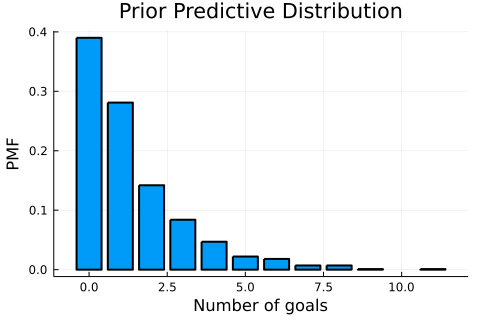

In [9]:
using Plots
bar(pmf_prior_pred, xlabel="Number of goals",
         ylabel="PMF",
         title="Prior Predictive Distribution")

## Introducing ~PyMC3~Turing

In [10]:
using Turing
@model function model(goals)
    λ ~ Gamma(1.4, 1.0)
    goals ~ Poisson(λ)
end

model (generic function with 2 methods)

## Sampling the Prior

In [11]:
# we pass `missing` as data for the prior predictive
trace = sample(model(missing), Prior(), 1000);

In [12]:
sample_prior_turing = vec(trace[:λ]);
size(sample_prior_turing)

(1000,)

In [13]:
"""Plot the CDF of a sample.

sample: sequence of quantities
"""
function plot_cdf!(sampl, args...; kwargs...)
    plot!(cdffromseq(sampl), args...; kwargs...)
end

plot_cdf!

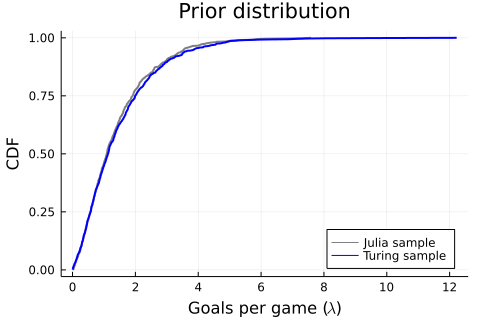

In [14]:
using LaTeXStrings
plot()
plot_cdf!(sample_prior, 
         label="Julia sample",
         color=:gray)
plot_cdf!(sample_prior_turing, 
         label="Turing sample",
         color=:blue)
plot!(xlabel=L"Goals per game ($\lambda$)",
         ylabel="CDF",
         title="Prior distribution", legend=:bottomright)

In [15]:
sample_prior_pred_turing = vec(trace[:goals])
size(sample_prior_pred_turing)

(1000,)

In [16]:
function plot_pred!(sample, args...; kwargs...)
    plot!(cdffromseq(sample), args...; linetype=:steppre, kwargs...)
end

plot_pred! (generic function with 1 method)

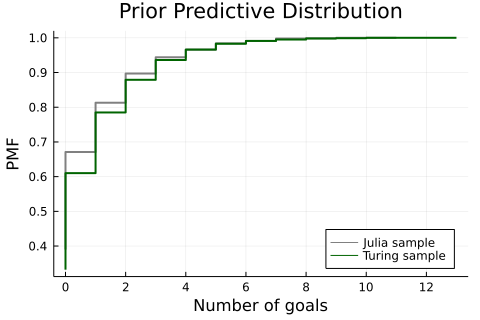

In [17]:
plot()
plot_pred!(sample_prior_pred, 
          label="Julia sample", 
          color=:gray)
plot_pred!(sample_prior_pred_turing, 
          label="Turing sample", 
          color=:darkgreen)
plot!(xlabel="Number of goals",
         ylabel="PMF",
         title="Prior Predictive Distribution", legend=:bottomright)

## When Do We Get to Inference?

In [18]:
# the model is already ready to go
# we pass the data into the model
@model function model(goals)
    λ ~ Gamma(1.4, 1.0)
    goals ~ Poisson(λ)
end

model (generic function with 2 methods)

In [19]:
data = 4
trace2 = sample(model(data), NUTS(), MCMCThreads(), 500, 2);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6500000000000001
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188


In [20]:
sample_post_turing = vec(trace2[:λ])
size(sample_post_turing)

(1000,)

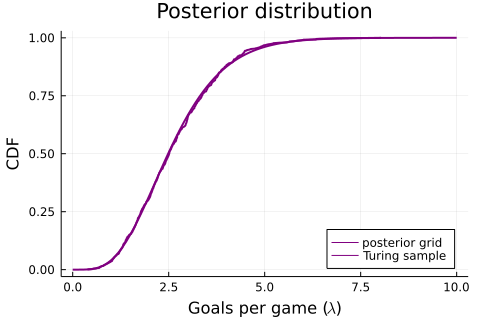

In [21]:
plot(makecdf(posterior), label="posterior grid", 
                          color=:purple)
plot_cdf!(sample_post_turing, 
         label="Turing sample",
         color=:purple)

plot!(xlabel=L"Goals per game ($\lambda$)",
         ylabel="CDF", legend=:bottomright,
         title="Posterior distribution")

## Posterior Predictive Distribution

In [22]:
post_pred = predict(model(missing), trace2);

In [23]:
sample_post_pred_turing = vec(post_pred[:goals]);

In [24]:
sample_post = rand(posterior, 1000)
sample_post_pred = rand.(Poisson.(sample_post));

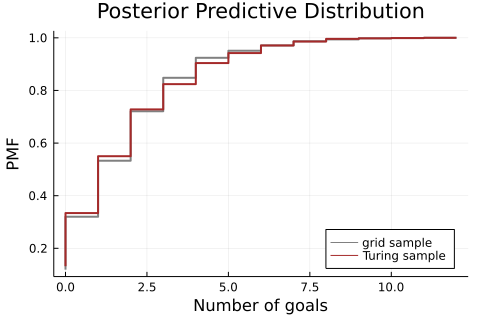

In [25]:
plot(xlabel="Number of goals",
         ylabel="PMF", 
         title="Posterior Predictive Distribution")
plot_pred!(sample_post_pred, 
          label="grid sample",
          color=:gray)
plot_pred!(sample_post_pred_turing, 
          label="Turing sample",
          color=:brown, legend=:bottomright)

## Happiness

In [26]:
getfile("https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls")

In [27]:
# unfortunately, there doesn't seem to be an .xls file reader for Julia (.xlsx files are supported
# via the XLSX package)

# we can cheat and use Python to convert the file to CSV:
using PyCall
py"""
import pandas as pd
pd.read_excel('WHR20_DataForFigure2.1.xls').to_csv("WHR20_DataForFigure2.1.csv")
"""

# now we can read the file...
using CSV, DataFrames
df = CSV.File("WHR20_DataForFigure2.1.csv") |> DataFrame;

In [28]:
first(df, 3)

,Column1,Country name,Regional indicator,Ladder score,Standard error of ladder score
,Int64,String,String,Float64,Float64
1,0,Finland,Western Europe,7.8087,0.0311563
2,1,Denmark,Western Europe,7.6456,0.0334923
3,2,Switzerland,Western Europe,7.5599,0.0350142


In [29]:
size(df)

(153, 21)

In [30]:
score = df[!, "Ladder score"];

## Simple Regression

In [31]:
log_gdp = df[!, "Logged GDP per capita"];

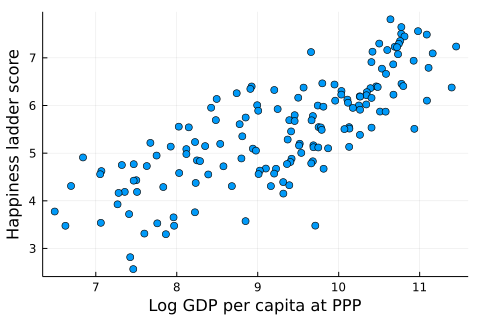

In [32]:
scatter(log_gdp, score, markertype=:dot,
         xlabel="Log GDP per capita at PPP",
         ylabel="Happiness ladder score")

In [33]:
# we could use GLM for this, but linear regression is simple enough
# that we just need a bit of linear algebra
function linregress(x, y)
    x = hcat(ones(length(x)),x)
    return inv(x'*x)*(x'*y)
end

result = linregress(log_gdp, score);

In [34]:
DataFrame(:index=>["Intercept", "Slope"], :coeffs => result)

,index,coeffs
,String,Float64
1,Intercept,-1.19865
2,Slope,0.717738


In [35]:
@model function model3(x, y)
    a ~ Uniform(0, 4)
    b ~ Uniform(-4, 4)
    σ ~ Uniform(0, 2)
    
    for i ∈ eachindex(y)
        y[i] ~ Normal(a * x[i] + b, σ)
    end
end

model3 (generic function with 2 methods)

In [36]:
x_data = log_gdp
y_data = score

trace3 = sample(model3(x_data, y_data), NUTS(), MCMCThreads(), 500, 2);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188


In [37]:
trace3

Chains MCMC chain (500×15×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 3.87 seconds
Compute duration  = 3.68 seconds
parameters        = a, b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           a    0.7164    0.0479     0.0015    0.0022   346.2345    0.9999     ⋯
           b   -1.1871    0.4475     0.0141    0.0205   345.8422    1.0004     ⋯
           σ    0.7131    0.0407     0.0013    0.0024   299.8165    1.0063     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97

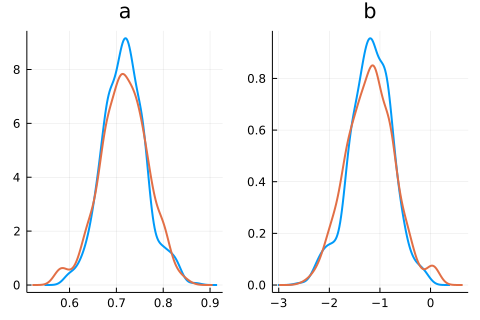

In [38]:
using StatsPlots; 
plot(layout=2)
density!(trace3[:a], subplot=1, title="a")
density!(trace3[:b], subplot=2, title="b")

In [39]:
println("Sample mean: $(mean(trace3[:a]))")
println("Regression slope: $(result[2])")

Sample mean: 0.7163959344368095
Regression slope: 0.7177384956304564


In [40]:
println("Sample mean: $(mean(trace3[:b]))")
println("Regression slope: $(result[1])")

Sample mean: -1.1870950767823476
Regression slope: -1.1986460618089723


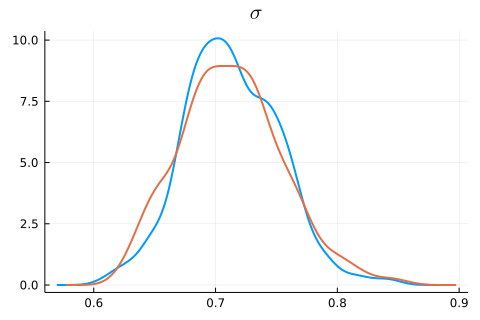

In [41]:
density(trace3[:σ], title=L"\sigma")

In [42]:
20 ^ 8 / 1e9

25.6

In [43]:
153 * 20 ^ 8 / 1e12

3.9168

## Multiple Regression

In [44]:
columns = ["Ladder score",
           "Logged GDP per capita",
           "Social support",
           "Healthy life expectancy",
           "Freedom to make life choices",
           "Generosity",
           "Perceptions of corruption"]

subset = df[!, columns];

In [45]:
first(subset, 3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices
,Float64,Float64,Float64,Float64,Float64
1,7.8087,10.6393,0.95433,71.9008,0.949172
2,7.6456,10.774,0.955991,72.4025,0.951444
3,7.5599,10.9799,0.942847,74.1024,0.921337


In [46]:
standardized = mapcols(x -> (x .- mean(x)) ./ std(x), subset);

# alternatively:
#   using MLDataUtils
#   standardized = copy(subset);
#   rescale!(standardized)

In [47]:
y_data = standardized[!, "Ladder score"];

In [48]:
x_data = Matrix(select(standardized, Not("Ladder score")));

x₁ = x_data[:, 1]
x₂ = x_data[:, 2]
x₃ = x_data[:, 3]
x₄ = x_data[:, 4]
x₅ = x_data[:, 5]
x₆ = x_data[:, 6];

In [49]:
@model function model4(x₁, x₂, x₃, x₄, x₅, x₆, y)
    b₀ ~ Uniform(-4, 4)
    b₁ ~ Uniform(-4, 4)
    b₂ ~ Uniform(-4, 4)
    b₃ ~ Uniform(-4, 4)
    b₄ ~ Uniform(-4, 4)
    b₅ ~ Uniform(-4, 4)
    b₆ ~ Uniform(-4, 4)


    σ ~ Uniform(0, 2)
    
    for i ∈ eachindex(y)
        y_est = b₀ + b₁ * x₁[i] + b₂ * x₂[i] + b₃*x₃[i] + b₄*x₄[i] + b₅*x₅[i] + b₆*x₆[i] 
        y[i] ~ Normal(y_est , σ)
    end
end

model4 (generic function with 2 methods)

In [50]:
trace4 = sample(model4(x₁, x₂, x₃, x₄, x₅, x₆, y_data), NUTS(), MCMCThreads(), 500, 2);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188


In [51]:
mean(trace4[:b₀])

-5.934129975105229e-6

In [52]:
mean(trace4[:σ])

0.5162062014341193

In [53]:
params = [:b₁, :b₂, :b₃, :b₄, :b₅, :b₆]

means = [mean(trace4[p])
         for p in params];

In [54]:
using StatsBase
"""Compute 94% credible interval."""
function credible_interval(sample)
    v = vec(sample) # collapse all chains
    ci = [percentile(v, p) for p in [3, 97]]
    return round.(ci, digits=3)
end
cis = [credible_interval(trace4[p])
       for p in params];

In [55]:
index = columns[2:end]
table = DataFrame("index"=>index, 
                  "Posterior mean" => round.(means, digits=3), 
                  "94% CI" => cis)

,index,Posterior mean,94% CI
,String,Float64,Array…
1,Logged GDP per capita,0.254,"[0.074, 0.426]"
2,Social support,0.295,"[0.152, 0.431]"
3,Healthy life expectancy,0.219,"[0.05, 0.384]"
4,Freedom to make life choices,0.191,"[0.09, 0.292]"
5,Generosity,0.054,"[-0.039, 0.145]"
6,Perceptions of corruption,-0.098,"[-0.192, 0.006]"


## Summary

## Exercises

In [56]:
# Solution

n = 250
k_obs = 140

@model function model5(k)
    x ~ Beta(1, 1)
    k ~ Binomial(n, x)
end

trace5 = sample(model5(k_obs), MH(), 500);



┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


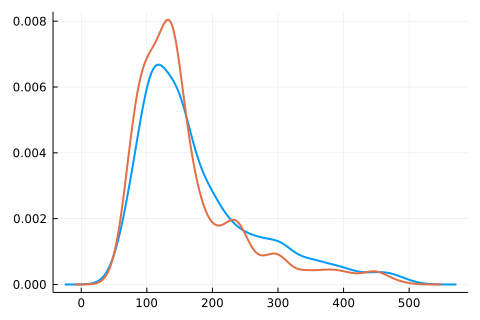

In [57]:
# Solution

# see https://discourse.julialang.org/t/trouble-translating-a-simple-pymc3-model-to-turing/71856

k = 23
n = 19
x = 4

@model function model6(k, n, y)
    N ~ DiscreteUniform(50, 500)
    y ~ Hypergeometric(k, N - k, n)
end
trace6 = sample(model6(k, n, x), MH(), MCMCThreads(), 500, 2);

density(trace6[:N])


In [58]:
data = [0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395];

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be

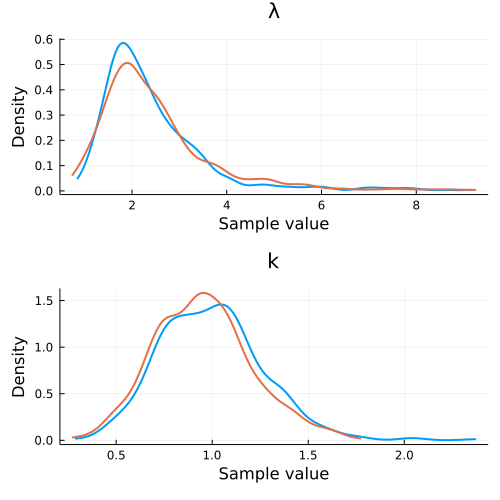

In [59]:
# Solution

@model function model7(y)
    λ ~ Uniform(0.1, 10.1)
    k ~ Uniform(0.1, 5.1)
    y ~ Weibull(k, λ)
end

trace6 = sample(model7(data), NUTS(), MCMCThreads(), 500, 2)

density(trace6)

In [60]:
getfile("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv")

In [61]:
df = DataFrame(CSV.File("drp_scores.csv", delim="\t", header=23, skipto=24))
first(df, 5)

,Treatment,Response
,String,Int64
1,Treated,24
2,Treated,43
3,Treated,58
4,Treated,71
5,Treated,43


In [62]:
grouped = groupby(df, "Treatment")
responses = Dict()

for (k, group) in pairs(grouped)
    name = k["Treatment"]
    responses[name] = group[!, "Response"]
end

In [63]:
data = responses["Treated"];

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/sunny/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sunny/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be

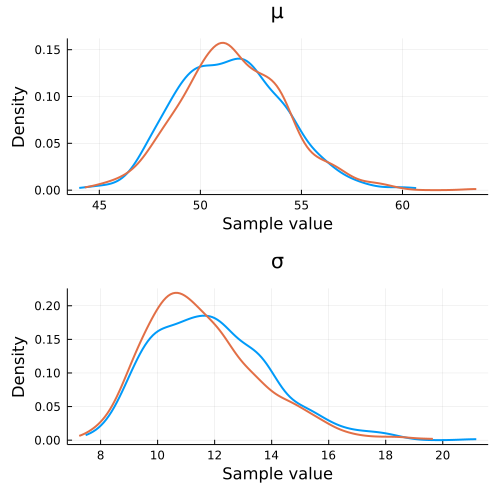

In [64]:
# Solution

@model function model8(y)
    μ ~ Uniform(20, 80)
    σ ~ Uniform(5, 30)
    y ~ Normal(μ, σ)
end

trace8 = sample(model8(data), NUTS(), MCMCThreads(), 500, 2)

density(trace8)

In [65]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

3

In [66]:
num_seen = k01 + k10 + k11
num_seen

32

In [67]:
# Solution

# see https://discourse.julialang.org/t/trouble-translating-a-simple-pymc3-model-to-turing/71856/
using AdvancedMH

@model function model9(k01, k10, k11)
    p0 ~ Beta(1, 1)
    p1 ~ Beta(1, 1)
    num_seen = k01 + k10 + k11
    N ~ DiscreteUniform(num_seen, 350)
    
    q0 = 1-p0
    q1 = 1-p1
    ps = [q0*q1, q0*p1, p0*q1, p0*p1]
    
    y = [N - num_seen, k01, k10, k11]
    Turing.@addlogprob!(logpdf(Multinomial(N, ps),y))
end
    
trace9 = sample(model9(k01, k10, k11),
            Gibbs(MH(:N => RandomWalkProposal(DiscreteUniform(-1, 1))), NUTS(1000,.8, :p0, :p1)), 3000; thinning=100,
            init_params=[.1,.1,100])

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/sunny/.julia/packages/Turing/nfMhU/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (3000×4×1 Array{Float64, 3}):

Iterations        = 1:100:299901
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 16.7 seconds
Compute duration  = 16.7 seconds
parameters        = p0, p1, N
internals         = lp

Summary Statistics
  parameters       mean       std   naive_se      mcse       ess      rhat   e ⋯
      Symbol    Float64   Float64    Float64   Float64   Float64   Float64     ⋯

          p0     0.2103    0.1133     0.0021    0.0129   12.6658    1.1627     ⋯
          p1     0.1619    0.0892     0.0016    0.0099   13.4713    1.1439     ⋯
           N   129.8510   72.8038     1.3292    9.5431    8.8554    1.2851     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%      50.0%      75.0%      97.5% 
      Symbol   Float64   Float64    Float64    Float64    Float64 

          p0    0.0620    0.1142     0.1916     0.2847     0.4681
          p1    0.0440    0.0859 

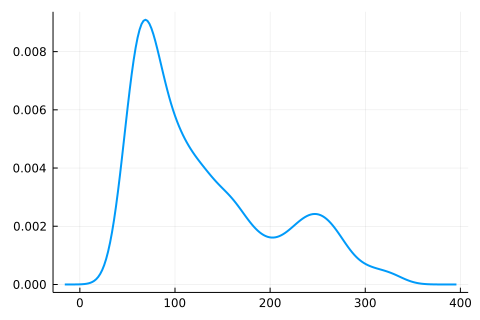

In [68]:
density(trace9[:N])

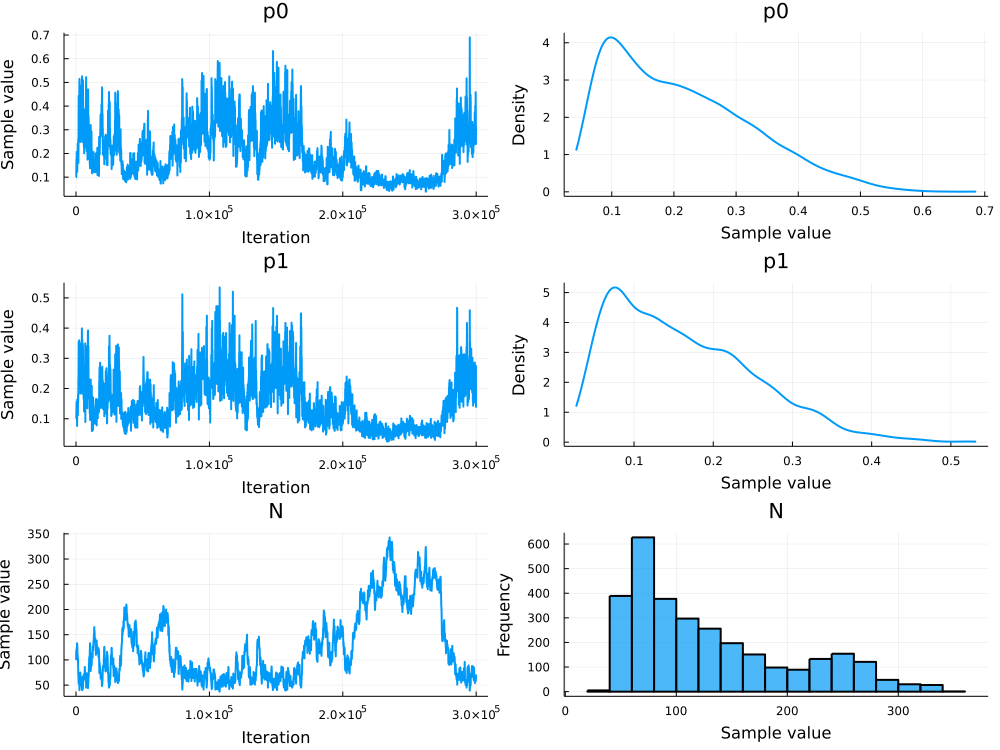

In [69]:
plot(trace9)